<a href="https://colab.research.google.com/github/boyoung21/ESAA/blob/main/0516_%EC%A3%BC%ED%83%9D%EA%B0%80%EA%B2%A9_%EC%98%88%EC%B8%A1_%EC%BA%90%EA%B8%80_%ED%95%84%EC%82%AC_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 주택 가격 예측 문제 - Stacking

In [11]:
# 데이터 확인하기 eda

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.stats import norm, skew # 데이터의 왜곡된 정도를 확인할 때 쓰는 라이브러리, 모듈
import warnings
warnings.filterwarnings('ignore') # warnings 무시
%matplotlib inline

# sns theme
sns.set_theme(style="darkgrid")

# 소수점 표현 제한
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

# 디렉토리 내, 사용가능 파일 체크
from subprocess import check_output
# print(check_output(["ls", "../input"]).decode("utf8"))

In [12]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [13]:
# 데이터체크
print(train_df.shape, test_df.shape)
train_df.head(5)

(1460, 81) (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


가격 특성 제외 80개의 특성 존재. 데이터 분석과 관계 없는 단순 식별자 ID 존재

In [14]:
# Save the 'Id' column
train_ID = train_df['Id']
test_ID = test_df['Id']

# drop the  'Id' colum since it's unnecessary for  the prediction process
train_df.drop("Id", axis = 1, inplace = True)
test_df.drop("Id", axis = 1, inplace = True)

# 데이터 전처리

1. outliers

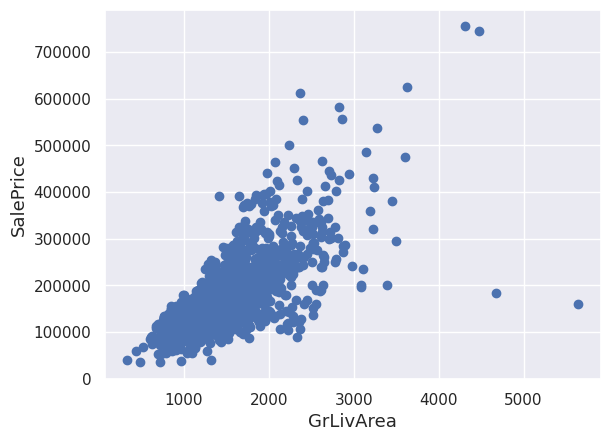

In [15]:
# 산점도로 GrLivArea와 SalePrice 관계 시각화
fig, ax = plt.subplots()

ax.scatter(x = train_df['GrLivArea'], y = train_df['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

오른쪽 아래는 일반적인 방향성을 벗어나는 이상치 -> 삭제 필요

이상치를 더 자세하게 찾아서 제거하지 않고 사진상으로 보이는 것만 제거한 이유는, 테스트 데이터에도 이상치가 있을 수 있기 때문에 이상치를 모두 제거하면 모델에 안 좋은 영향을 미칠 수 있음. 이런 이상치를 모두 제거하는 대신 후에 모델에서 이런 데이터를 제어하는 방법에 대해서 다룰 것.

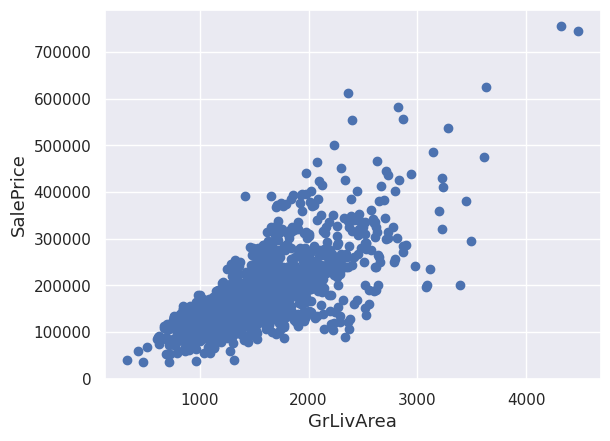

In [16]:
# Deleting outlier
train_df = train_df.drop(train_df[(train_df['GrLivArea']>4000) &
 (train_df['SalePrice']<300000)].index)

# Check the Graphic again
fig, ax = plt.subplots()
ax.scatter(x = train_df['GrLivArea'], y = train_df['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

# Target Variable

우리가 예측해야 하는 타깃값으로 q-q plot으로 두 데이터 집단 간의 분포 체크

180932.91906721535 79467.78892987774


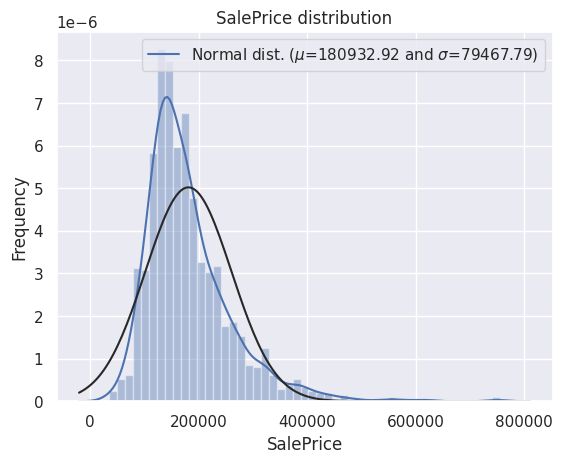

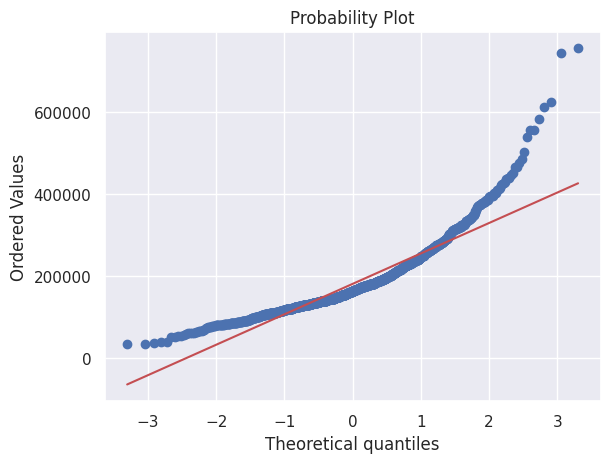

In [17]:
sns.distplot(train_df['SalePrice'], fit=norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train_df['SalePrice'])
print(mu, sigma)

# 분포를 그래프에 그려봅시다
plt.legend(['Normal dist. ($\mu$={:.2f} and $\sigma$={:.2f})'.format(mu,sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

# QQ-plot을 그려봅시다.
fig = plt.figure()
res = stats.probplot(train_df['SalePrice'], plot=plt)
plt.show()

분포가 오른쪽으로 치우쳤으므로 선형 모델에 적용하기 위해 로그 변환 이용 : 모든 칼럼 원소에 log(1+x)

12.024015155682552 0.3995757283645756


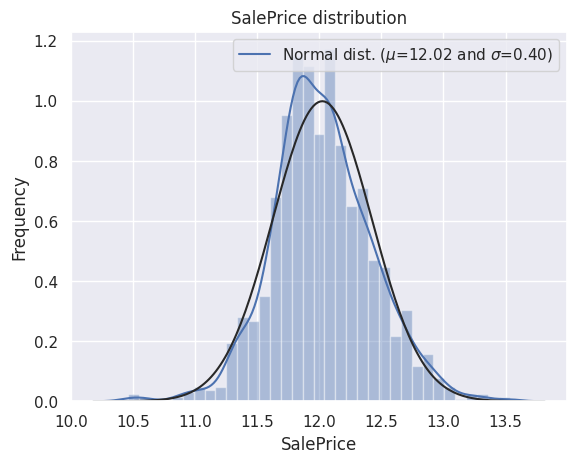

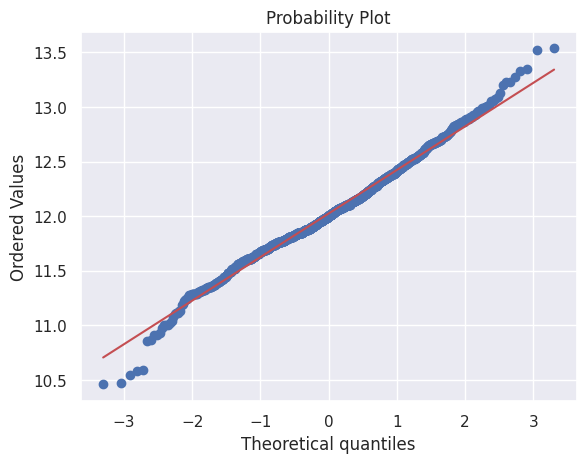

In [18]:
train_df['SalePrice'] = np.log1p(train_df['SalePrice'])

# 위에서와 같은 코드로 똑같이 분포를 확인해봅니다.
sns.distplot(train_df['SalePrice'], fit=norm)
(mu, sigma) = norm.fit(train_df['SalePrice'])
print(mu, sigma)
plt.legend(['Normal dist. ($\mu$={:.2f} and $\sigma$={:.2f})'.format(mu,sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')
fig = plt.figure()
res = stats.probplot(train_df['SalePrice'], plot=plt)
plt.show()

# Feature Engineering

- 처리에 앞서 train과 test의 데이터를 하나로 묶어 줌

In [19]:
ntrain = train_df.shape[0]
ntest = test_df.shape[0]

y_train = train_df.SalePrice.values

all_data = pd.concat((train_df, test_df)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


전체 데이터에서 결측치를 찾기 -> 결측치 개수를 전체 데이터 대비 비율로 표시

In [20]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]

missing_data = pd.DataFrame({"Missing Ratio" : all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.691
MiscFeature,96.400
Alley,93.212
Fence,80.425
MasVnrType,60.542
FireplaceQu,48.680
LotFrontage,16.661
GarageQual,5.451
GarageYrBlt,5.451
GarageCond,5.451


Text(0.5, 1.0, 'Percent missing data by feature')

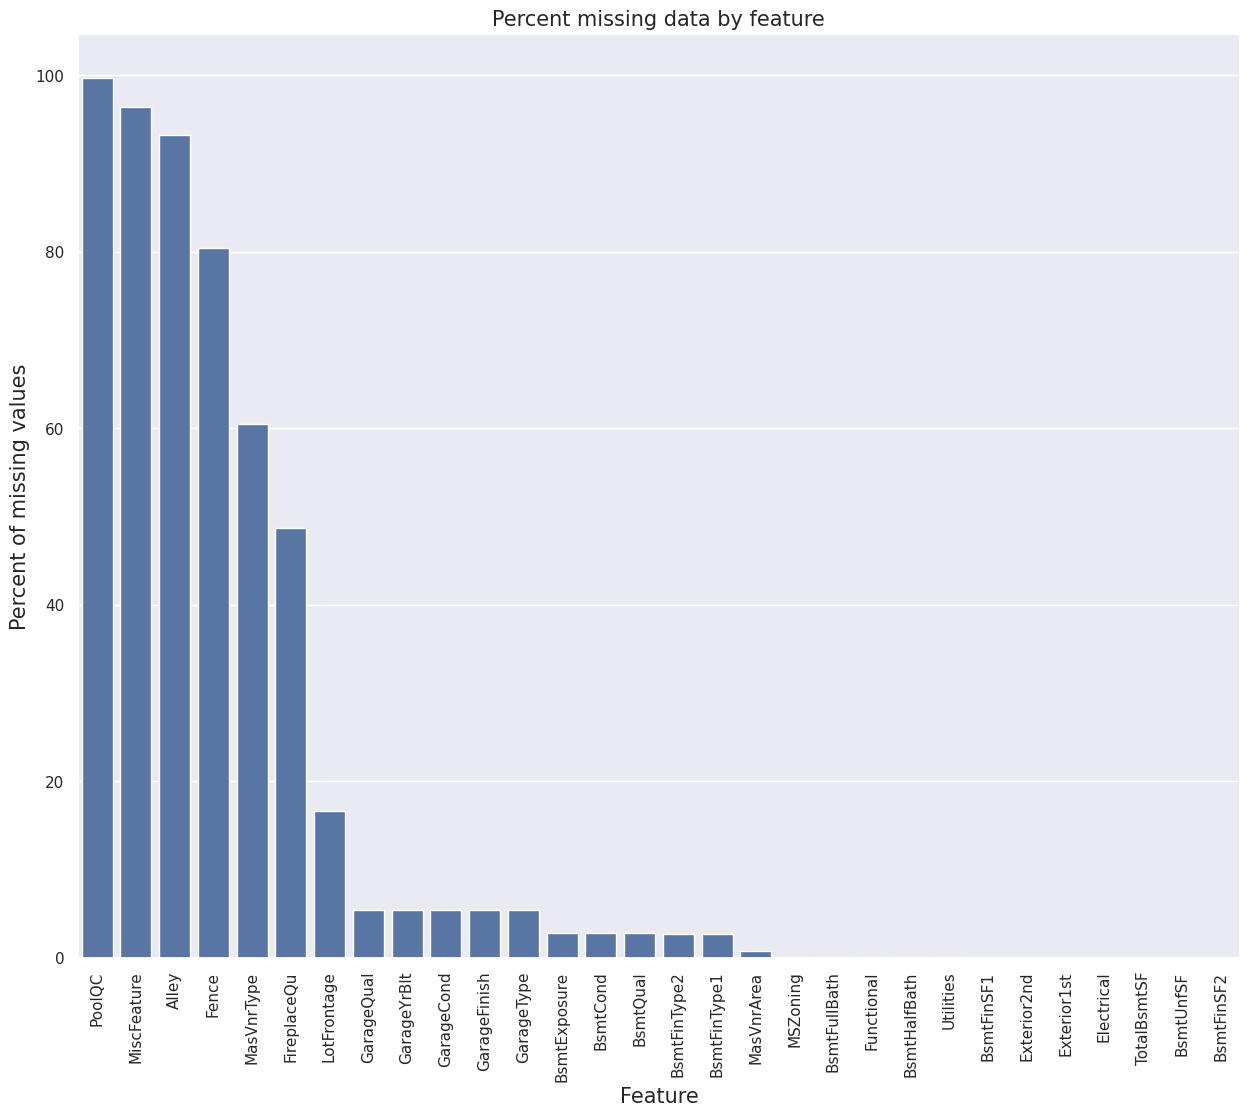

In [21]:
f, ax = plt.subplots(figsize=(15,12))
plt.xticks(rotation=90)
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Feature', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

# Data Correlation
heatmap을 이용해 각 요소의 상관관계를 시각화하여 더 직관적으로 파악

- SalePrice와 다른 요소 간의 상관관계 시각화

<Axes: >

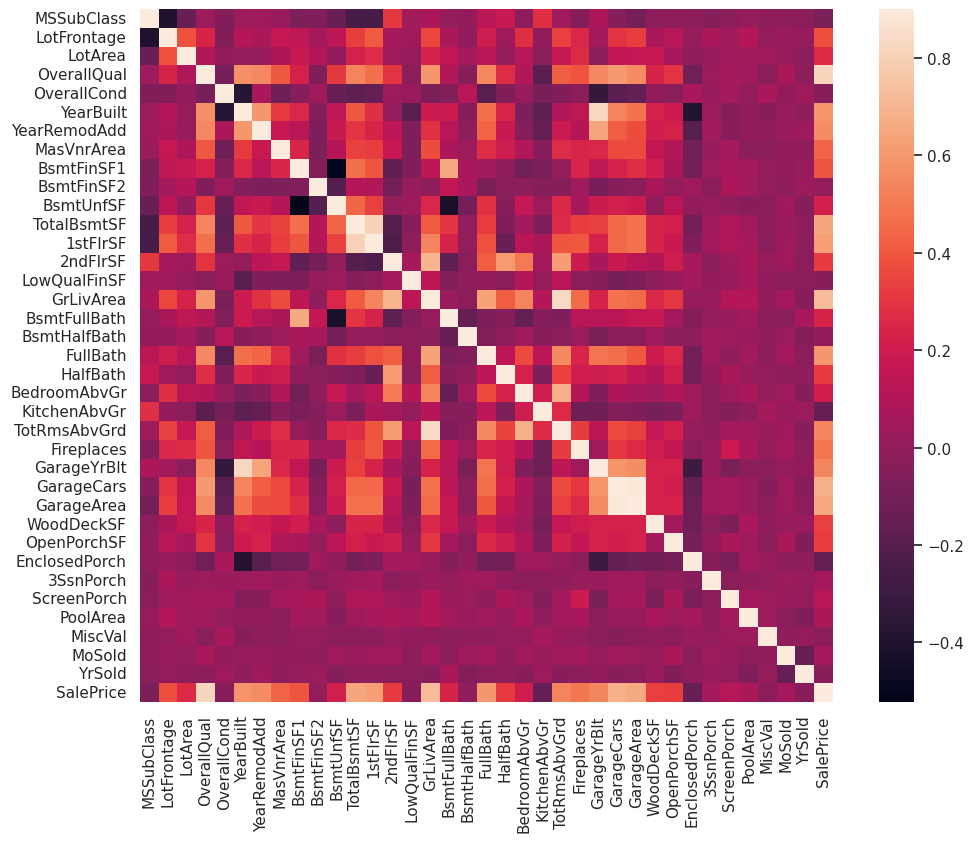

In [24]:
# 숫자형 컬럼만 corr 가능

corrmat = train_df.select_dtypes(include=['number']).corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

# 누락된 값 채워넣기

- PoolQC: NA는 no pool 의미. 99퍼의 결측치 채우기

- MiscFeature: NA는 no misc feature, alley, fence, fireplacequ도 동일

-lotfrontage: 거리와 집의 거리 요소. 손실값은 중앙값으로

- GarageType, GarageFinish, GarageQual and GarageCond: none 처리

- MSZoning (The general zoning classification) : RL이 최빈값으로 빈 부분은 RL로 채움.

In [25]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")

In [26]:
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

In [27]:
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x : x.fillna(x.median()))

In [28]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

In [30]:
# 빈데이터들은 'None' 또는 0 처리

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

In [31]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

In [32]:
# 예측에 도움되지 않을 것 같은 칼럼은 삭제
all_data = all_data.drop(['Utilities'], axis=1)

In [33]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")

In [34]:
# 모두 최빈값으로 채운 뒤 MSSubClass는 None

all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")


In [35]:
# 채우지 못한 데이터 있는지 확인

#Check remaining missing values if any
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


# 수치형 값들 중 범주형인 특성들 변환

In [36]:
# MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

# Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].apply(str)

# Year and Month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [37]:
# 범주형 데이터 라벨 인코딩 변환

from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond',
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1',
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond',
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder()
    lbl.fit(list(all_data[c].values))
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 78)


In [38]:
# 집의 가용 평수 변수들을 하나로 합쳐 새로운 특성 생성

all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

In [39]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# 수치형 데이터에서 skewness 체크
skewed_feats = all_data[numeric_feats].apply(lambda x : skew(x.dropna())).sort_values(ascending=False)

print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.940
PoolArea,17.689
LotArea,13.109
LowQualFinSF,12.085
3SsnPorch,11.372
LandSlope,4.973
KitchenAbvGr,4.301
BsmtFinSF2,4.145
EnclosedPorch,4.002
ScreenPorch,3.945


로그 변환 말고도 정규 분포 형태로 변환해 주는 box-cox 사용하여 데이터 변환

In [40]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)

There are 59 skewed numerical features to Box Cox transform


In [42]:
# 범주형 데이터를 get_dummies로 원핫 인코딩 후 train/test 분리

all_data = pd.get_dummies(all_data)
print(all_data.shape)

train_df = all_data[:ntrain]
test_df = all_data[ntrain:]

(2917, 220)


In [43]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [44]:
# Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train_df.values)
    rmse = np.sqrt(-cross_val_score(model, train_df.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return (rmse)

Lasso Regression은 이상치에 매우 민감한 모델이므로 pipeline에 RobustScaler() 메서드를 이용

Elastic Net Regression 역시 이상치를 위해 똑같이 함

In [45]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

In [46]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

In [47]:
# huber 손실 함수로 이상치를 관리

GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4,
                                   max_features='sqrt', min_samples_leaf=15, min_samples_split=10,
                                   loss='huber', random_state=5)

In [48]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468,
                             learning_rate=0.05, max_depth=3,
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [50]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [51]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1115 (0.0074)



In [52]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1116 (0.0074)



In [53]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1153 (0.0075)



In [54]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1167 (0.0083)



In [55]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.1162 (0.0078)



In [56]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319

Stacking models

1. 모델들의 성능을 평균하여 사용하는 것으로 시작

In [57]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models

    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]

        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self

    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

In [58]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print("Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Averaged base models score: 0.1087 (0.0077)



# Less simple Stacking : Adding a Meta - model

meta model을 추가하고, base model들의 평균과 이 out-of-folds 예측을 이용하여 meta-model 훈련

기본적인 흐름

1. 훈련 데이터를 분리된 데이터셋 train, holdout으로 나눔.
2. train 데이터로 훈련.
3. holdout 데이터로 테스트.
4. 3을 통해 예측값을 구하고, meta model을 통해 그 예측 값으로 모델을 학습.

ex) 5-folds

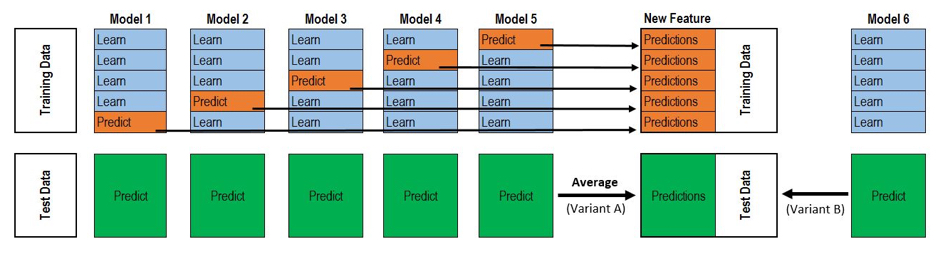

In [59]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds

    # base_models_는 2차원 배열입니다.
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)

        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred

        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self

    # 각 모델들의 평균값을 사용합니다.
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [60]:
stacked_averaged_models = StackingAveragedModels(
    base_models=(ENet, GBoost, KRR),
    meta_model=(lasso)
)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1081 (0.0073)


In [61]:
# rmsle 함수 정의 후 위에서 만든 XGBoost와 LightGBM을 이용해 최종 결과 생성

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [63]:
stacked_averaged_models.fit(train_df.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train_df.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test_df.values))
print(rmsle(y_train, stacked_train_pred))

0.078395060966657


In [64]:
model_xgb.fit(train_df, y_train)
xgb_train_pred = model_xgb.predict(train_df)
xgb_pred = np.expm1(model_xgb.predict(test_df))
print(rmsle(y_train, xgb_train_pred))

0.08632034929442625


In [65]:
model_lgb.fit(train_df, y_train)
lgb_train_pred = model_lgb.predict(train_df)
lgb_pred = np.expm1(model_lgb.predict(test_df.values))
print(rmsle(y_train, lgb_train_pred))

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.23

In [67]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.70 +
               xgb_train_pred*0.15 + lgb_train_pred*0.15 ))

RMSLE score on train data:
0.0764283320422573


# Ensemble prediction

In [68]:
ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

In [69]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv('submission.csv',index=False)